# Compare opsim databases using TDEsMetric

**[Opsim Databases](http://astro-lsst-01.astro.washington.edu:8080/)**

- [baseline2018](#baseline2018.db)
- [colossus_2665](#colossus_2665.db)
- [colossus_2667](#colossus_2667.db)
- [pontus_2573](#pontus_2573.db)
- [pontus_2579](#pontus_2579.db)
- [mothra_2049](#mothra_2049.db)
- [pontus_2489](#pontus_2489.db)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.plots as plots

# open database use OpsimDatabase
# opsdb = db.OpsimDatabase('baseline2018a.db')

# output
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)


import [TDEsMetricTest](https://github.com/xiaolng/maf/blob/master/TDEsMetricTest.py)

In [7]:
from mycode.TDEsMetricTest import TDEsMetricTest
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots

**Minimum requirement for detection TDEs**

- one detection before peak in any band,  set nObsPrePeak=1;
- detections in three different bands within 5 days of peak, set nFiltersNearPeak=3, and nearPeakT=5;
- detections at least two bands post peak, set nFiltersPostPeak=2.

In [4]:
# light curve file
asciifile = 'TDEfaintfast_z0.1.dat'

# query columns 
mjdCol = 'observationStartMJD'
m5Col = 'fiveSigmaDepth'
filterCol = 'filter'
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}

# light curve parameters
epochStart = -22
peakEpoch = 0
nearPeakT = 5
nPhaseCheck = 1

# condition parameters
nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nObsPrePeak = 1
nObsNearPeak={'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}
nFiltersNearPeak = 3
nObsPostPeak=0 
nFiltersPostPeak = 2



In [4]:
# plot light curve
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter', err_key = None):
    # Input: dataSlice, padas DataFrame or numpy ndarray
    
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(10, 6))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]
        
        if err_key!=None:
            mag_err = dataSlice[err_key][fmatch]
            plt.errorbar(time, mag, yerr=mag_err, color=colors[f], fmt='.', label=f)
        else:
            plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

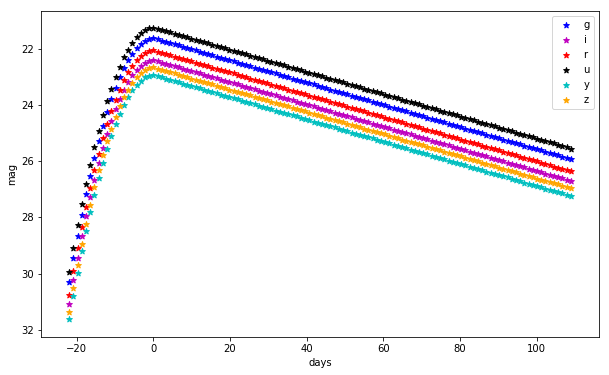

In [5]:
asciifile = 'TDEfaintfast_z0.1.dat'

lcv_template = np.genfromtxt(asciifile, dtype=[('ph', 'f8'), ('mag', 'f8'), ('flt', 'S1')])

df = pd.DataFrame()
df['ph'] = lcv_template['ph']
df['mag'] = lcv_template['mag']
df['flt'] = lcv_template['flt'].astype(str)

plotlc(df, time_key='ph', mag_key='mag', filter_key='flt')

## baseline2018.db

Project-official baseline (official opsim v4 baseline, 6/2018). No dome crawl.	

In [5]:
opsdb_baseline = db.OpsimDatabase('baseline2018a.db')

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['observationStartMJD', 'filter', 'fieldDec', 'fieldRA', 'fiveSigmaDepth']
Found 361353 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.00867719  dipole: lon: 158.059, lat: -12.4938, amp: 0.00869367
Plotting complete.


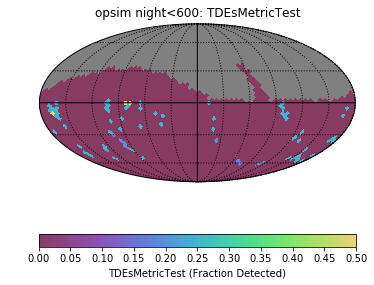

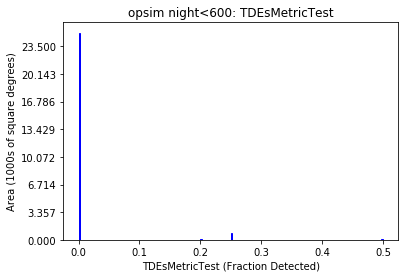

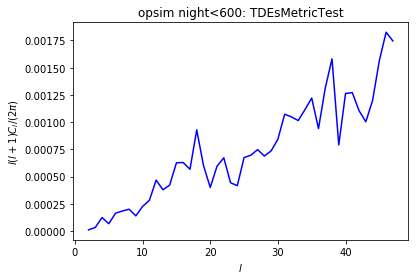

In [6]:
## get skymap
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


In [8]:
## get light curve
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=5, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=True)

ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)



Finish initializing metric
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 361353 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


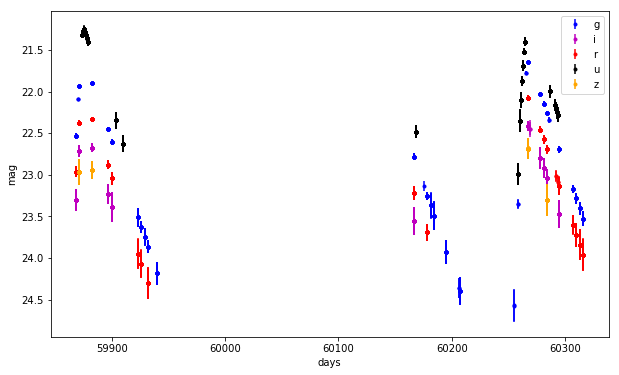

In [9]:
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

plotlc(df[df['lcAboveThresh']==True], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')



## colossus_2665.db

Baseline style, with slightly expanded WFD footprint to better satisfy SRD constraints on fO.

In [10]:
opsdb_colossus_2665 = db.OpsimDatabase('colossus_2665.db')

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 371345 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.00757354  dipole: lon: 155.454, lat: -59.4622, amp: 0.0282714
Plotting complete.


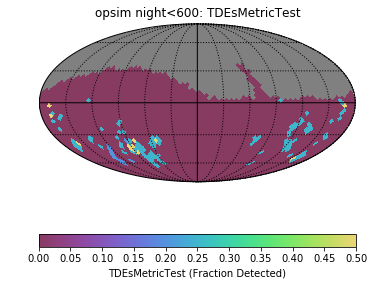

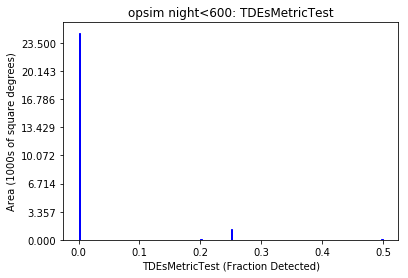

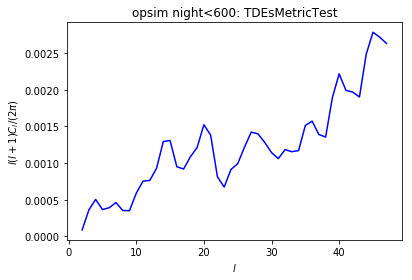

In [11]:
## get skymap
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=5, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_colossus_2665, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


In [12]:
## get light curve
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=5, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=True)

ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_colossus_2665, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


Finish initializing metric
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 371345 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


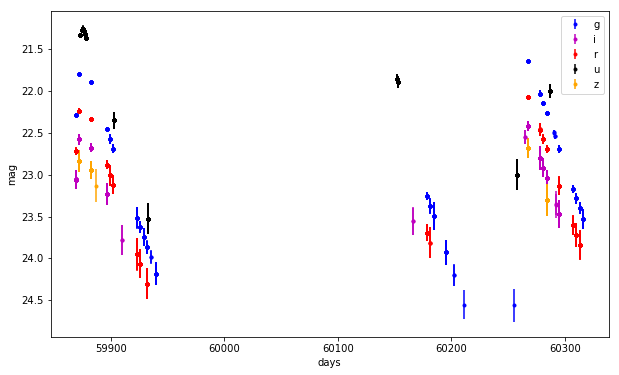

In [14]:
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

plotlc(df[df['lcAboveThresh']], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')


## colossus_2667.db

Survey with single visits only. Standard visits in pairs each night replaced with single visits per night.	

In [15]:
opsdb_colossus_2667 = db.OpsimDatabase('colossus_2667.db')

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 383368 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0322696  dipole: lon: -163.61, lat: 27.4527, amp: 0.0260893
Plotting complete.


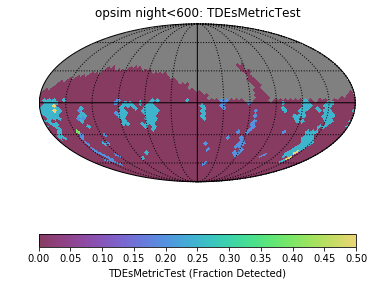

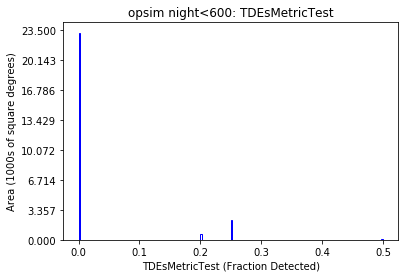

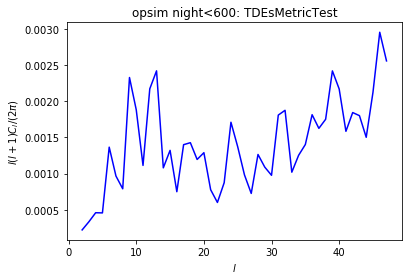

In [16]:
## get skymap
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_colossus_2667, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


In [40]:
## get light curve
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=True)

ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_colossus_2667, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

Finish initializing metric
Querying database SummaryAllProps with constraint night<600 for columns ['fieldDec', 'observationStartMJD', 'filter', 'fiveSigmaDepth', 'fieldRA']
Found 383368 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


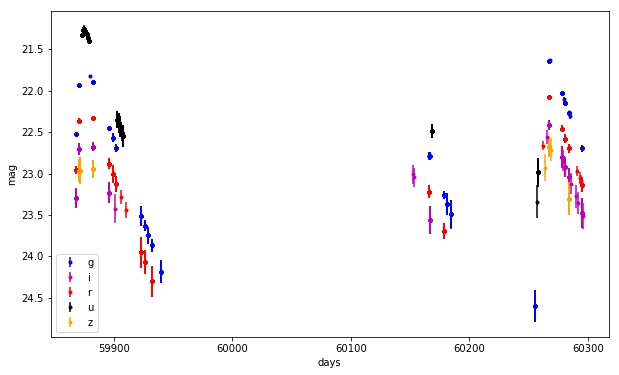

In [41]:
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

plotlc(df[df['lcAboveThresh']==True], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')


## pontus_2573.db

A baseline configuration but with mixed-filter pairs (g+r+i, uzy same-filter). FBS.	

In [18]:
opsdb_pontus_2573 = db.OpsimDatabase('pontus_2573.db')

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 369875 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
monopole: 0.0872992  dipole: lon: 59.7229, lat: -30.7732, amp: 0.0516592
Plotting complete.


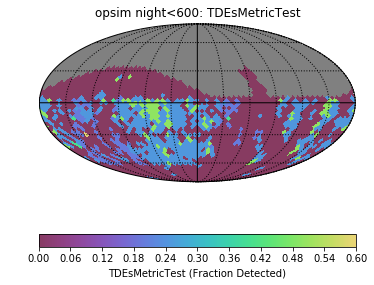

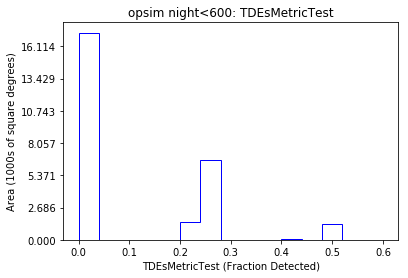

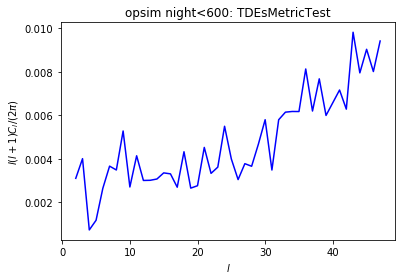

In [20]:
## get skymap
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2573, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)



In [43]:
## get light curve
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=5, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=True)

ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2573, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


Finish initializing metric
Querying database SummaryAllProps with constraint night<600 for columns ['fieldDec', 'observationStartMJD', 'filter', 'fiveSigmaDepth', 'fieldRA']
Found 369875 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


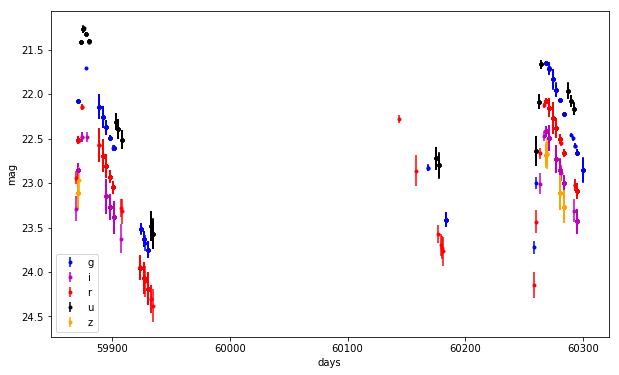

In [44]:
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

plotlc(df[df['lcAboveThresh']], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')



## pontus_2579.db

A rolling cadence run with 2 declination bands, which gently alternate per year. Observations in the "off year" band reach about 25% of the mean level, while "on years" hit 75% of the mean number of observations.	

In [21]:
opsdb_pontus_2579 = db.OpsimDatabase('pontus_2579.db')

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 370795 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0174212  dipole: lon: 55.0884, lat: -6.77569, amp: 0.00774839
Plotting complete.


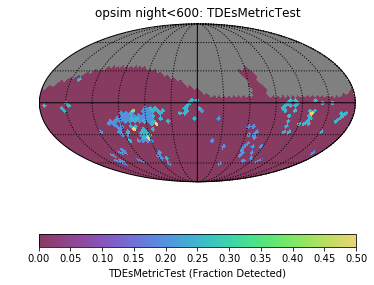

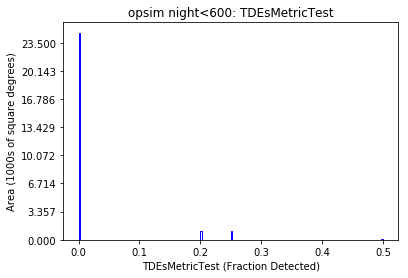

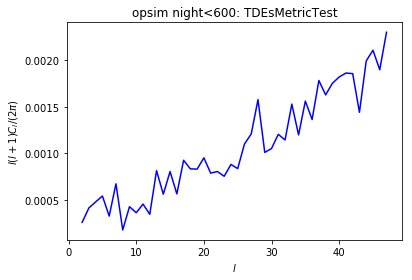

In [22]:
## get skymap
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2579, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

In [53]:
## get light curve
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=True)

ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<600'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2579, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)


Finish initializing metric
Querying database SummaryAllProps with constraint night<600 for columns ['fieldDec', 'observationStartMJD', 'filter', 'fiveSigmaDepth', 'fieldRA']
Found 370795 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


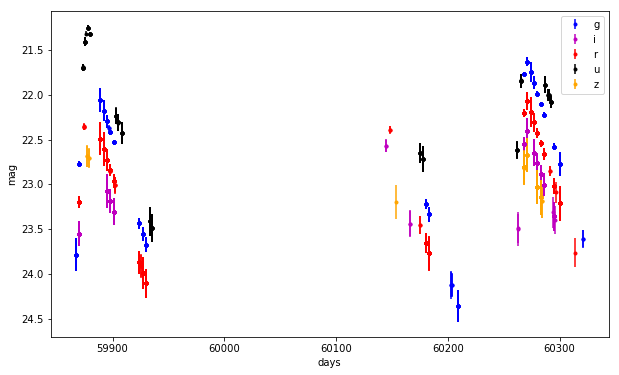

In [54]:
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

plotlc(df[df['lcAboveThresh']], time_key='expMJD', mag_key='lcMags', filter_key='filters', err_key='lcMagsStd')



## mothra_2049

A rolling cadence on a very large WFD footprint (24,700 sq deg). Two regions of declination, alternating on/off every other year throughout entire survey.	

In [24]:
opsdb_mothra_2049 = db.OpsimDatabase('mothra_2049.db')


Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 377472 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0854516  dipole: lon: -177.481, lat: 64.1588, amp: 0.108944
Plotting complete.


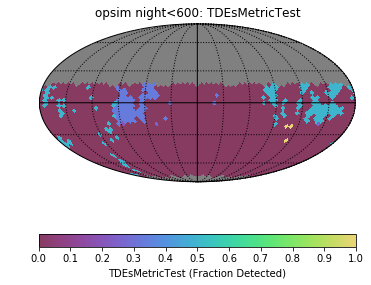

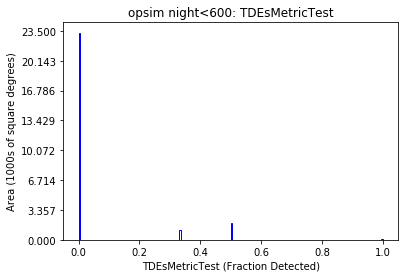

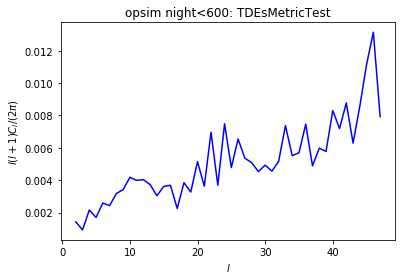

In [25]:
## get skymap
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_mothra_2049, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

## pontus_2489

Survey with more visits. Standard 2x15s visits replaced with 1x20s in grizy and 1x40s in u band.

In [27]:
opsdb_pontus_2489 = db.OpsimDatabase('pontus_2489.db')

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<600 for columns ['fieldRA', 'fieldDec', 'observationStartMJD', 'fiveSigmaDepth', 'filter']
Found 525957 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<600" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0199403  dipole: lon: 174.74, lat: -43.2239, amp: 0.0217434
Plotting complete.


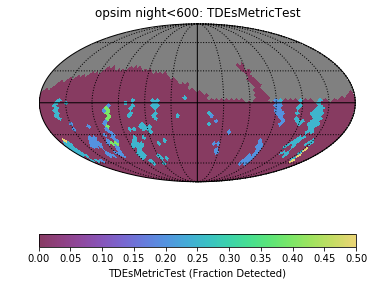

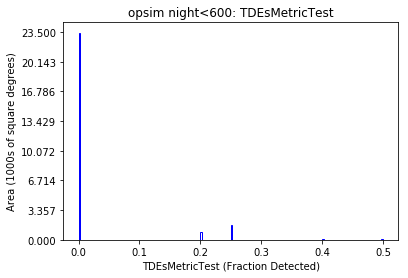

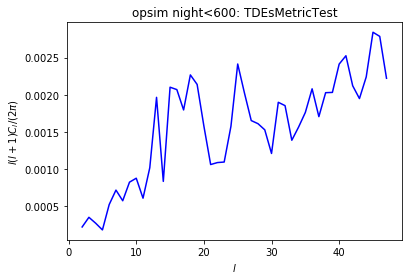

In [28]:
## get skymap
transmetric = TDEsMetricTest(asciifile=asciifile, mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol, 
                 detectSNR=detectSNR,
                 epochStart=epochStart, peakEpoch=peakEpoch, nearPeakT=nearPeakT, nPhaseCheck=nPhaseCheck,
                 nObsTotal= nObsTotal,nObsPrePeak=nObsPrePeak, 
                 nObsNearPeak=nObsNearPeak, nFiltersNearPeak=nFiltersNearPeak, 
                 nObsPostPeak=nObsPostPeak, nFiltersPostPeak=nFiltersPostPeak,
                 dataout=False)

slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<600'

transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb_pontus_2489, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

## Summary

In [65]:
df_sum = pd.DataFrame()
df_sum['Opsim'] = ['baseline2018','colossus_2665','colossus_2667','pontus_2573','pontus_2579']
df_sum['nights'] = [600, 600, 600, 600, 600]
df_sum['Fraction Detected'] = [0.007, 0.008, 0.039, 0.082, 0.014]
df_sum


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21.2 µs


,Opsim,nights,Fraction Detected
0,baseline2018,600,0.007
1,colossus_2665,600,0.008
2,colossus_2667,600,0.039
3,pontus_2573,600,0.082
4,pontus_2579,600,0.014
